<a href="https://colab.research.google.com/github/svetlanama/Data-Science-in-Finance-/blob/main/DSIF9_0_Time_series_modelling_in_Financial_Services.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction



## Agenda:
1. Time series data prep
2. Time series decomposition
3. Forecasting methods and model families


Demo: Implementation in Python
------------------------------

### LendingClub Use Case


---


### Set up

#### User-specified parameters

In [ ]:
python_material_folder_name = "python-material"

#### Import libraries

In [ ]:
import matplotlib.pyplot as plt
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Check if in Google Colab environment
try:
    from google.colab import drive
    # Mount drive
    drive.mount('/content/drive')
    # Set up path to Python material parent folder
    path_python_material = rf"drive/MyDrive/{python_material_folder_name}"
        # If unsure, print current directory path by executing the following in a new cell:
        # !pwd
    IN_COLAB = True
except:
    IN_COLAB = False
    # If working locally on Jupyter Notebook, parent folder is one folder up (assuming you are using the folder structure shared at the beginning of the course)
    path_python_material = ".."

# Import data
This time, we will be retrieving Apple's stock prices using an API with the yfinance library, a popular wrapper around Yahoo Finance's public APIs.

In [ ]:
import yfinance as yf
# Define the ticker symbol for Apple Inc.
chosen_stock = 'AAPL'

# Use yfinance to download the stock data
stock_data = yf.download(chosen_stock, start='2015-01-01', end='2025-03-06', interval='1d')

# Display the first few rows of the data
stock_data.tail()



In [ ]:
stock_data.shape

Let's plot the time series:

In [ ]:
def plot_stock_price(stock_data, ticker):

     # Plot the closing price data
    plt.figure(figsize=(10, 6))
    plt.plot(stock_data['Close'], label=f"{ticker} closing price")
    plt.title(f"{ticker} closing prices")
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()

plot_stock_price(stock_data, chosen_stock)

# 1. Time series data prep

In [ ]:
# Ensure the index is a DatetimeIndex
stock_data.index = pd.to_datetime(stock_data.index)


In [ ]:
# Set the frequency of the time series to 'B' (business day)
stock_data = stock_data.asfreq('B')



### Check for null values

In [ ]:
nas = stock_data['Close'].isna().sum()[0]
print(f"Null values: {nas} \n \n")

if nas > 0:
    print("Example NAs (head):")
    print(stock_data[stock_data['Close'].isna()].head(1))
    print("Example NAs (tail):")
    print(stock_data[stock_data['Close'].isna()].tail(1))


In [ ]:
plot_stock_price(stock_data.tail(30), chosen_stock)

In [ ]:
## Forward fill to handle missing data points (optional, depending on the data)
stock_data['Close'] = stock_data['Close'].ffill()

nas = stock_data['Close'].isna().sum()
print(f"Null values: {nas} \n \n")


In [ ]:
stock_data['Close'].tail(30)

Note: We would want to capture information on which data points were originally null, and also methodology used to fill them.  
For mor methods for dealing with missing values in time-series data, see [here](https://www.geeksforgeeks.org/how-to-deal-with-missing-values-in-a-timeseries-in-python/?ref=ml_lbp).  
Other useful link [here](https://gking.harvard.edu/files/pr.pdf).

### Are weekends included?

In [ ]:
weekends = stock_data.index[stock_data.index.weekday >= 5]

if len(weekends) > 0:
    print("Weekends are included in the time series.")
    print(weekends)  # Optionally print which dates are weekends
else:
    print("No weekends are included in the time series.")


# 2. Time series decomposition

**Time series decomposition** is the process of breaking down a time series into its fundamental components:
- **Trend**: The long-term movement in the data. For instance, an upward or downward trend in stock prices.
- **Seasonality**: Short-term, regular variations in data, often tied to calendar seasons or other recurring events.
- **Residuals (Noise)**: The random variation that is not explained by the trend or seasonality.

This helps in understanding the underlying patterns in the data and is useful for forecasting and analysis.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Let's bring back the plot
plot_stock_price(stock_data, chosen_stock)

### Additive vs. Multiplicative time series
If the magnitude of seasonal fluctuations increases as the trend increases, the series likely follows a multiplicative model.   
If the seasonal variations remain roughly constant, the series is likely additive.  

### <span style="color:BLUE"> **>>> DISCUSSION:**  </span>    
> What do you think is true in this case?


In [ ]:
# Decompose the time series (using 'Adj Close' prices)
decomposition = seasonal_decompose(stock_data['Close']
                                   , model='multiplicative'
                                   , period=252)


The number 252 is commonly used in financial data analysis to represent the number of trading days in a year because stock markets are usually open for about 252 days annually (excluding weekends and holidays).

By setting period=252, you are telling the decomposition to detect seasonal patterns that repeat roughly every 252 trading days, i.e., annually.

### Extrapolating components

In [ ]:
# Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid



In [ ]:
# Plot the decomposition
plt.figure(figsize=(10,8))
plt.subplot(4,1,1)
plt.plot(stock_data['Close'], label='Original')
plt.legend(loc='best')

plt.subplot(4,1,2)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(4,1,3)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(4,1,4)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.show()


### First glance interpretation

### <span style="color:BLUE"> **>>> DISCUSSION:**  </span>    
> What can we observe in the time series?

____________

Hypothesis: seasonal spike detected in relation to Apple's Development Conference in September?

In [ ]:
# Highlight iPhone release period (September)
plt.figure(figsize=(10,8))
plt.plot(seasonal, label='Seasonality')
for year in range(2015, 2024):
    plt.axvspan(f'{year}-09-01', f'{year}-09-30'
                , color='blue'
                , alpha=0.3
                , label='iPhone Release (Sept)' if year == 2015 else "")

plt.legend(loc='best')
plt.title('Apple ptock price seasonality with iPhone release period highlighted')
plt.show()



Let's look at actual prices..

In [ ]:
# Highlight iPhone release period September
plt.figure(figsize=(10,8))
plt.plot(stock_data['Close'], label='Original')

# Highlight and September
for year in range(2015, 2024):
        plt.axvspan(f'{year}-09-01', f'{year}-09-30'
                , color='blue'
                , alpha=0.3
                , label='iPhone Release (Sept)' if year == 2015 else "")

plt.legend(loc='best')
plt.title('Apple ptock price with iPhone release highlighted')
plt.show()

### Explaining decomposition

#### 1\. **Additive Decomposition**

In the **additive** model, the time series is assumed to be the sum of its components:

Y(t) = T(t) + S(t) + R(t)

It's appropriate when the seasonality does not vary with the level of the time series (e.g., if the seasonal effect is a constant absolute amount).
E.g.: If sales increase by $1000 every December regardless of the overall trend (whether the company is growing or shrinking), then an additive model might be suitable.

#### 2\. **Multiplicative Decomposition**

In the **multiplicative** model, the time series is assumed to be the product of its components:

Y(t)= T(t) × S(t) × R(t)

It's appropriate when the seasonality varies proportionally with the level of the time series (e.g., if the seasonal effect is a percentage of the trend).
E.g.: Sales triple every December compared to other months. If the overall sales are increasing, the seasonal effect (December sales spike) also increases proportionally.

In the multiplicative case, notice how the seasonal component's magnitude varies with the level of the trend. This makes the multiplicative model more appropriate when the seasonal effect is proportional to the trend level.

In [ ]:
def decom_report(decomposition_df, date):

    actual = decomposition.observed[date]
    trend = decomposition.trend[date]
    seasonal = decomposition.seasonal[date]
    residual = decomposition.resid[date]
    print(f"""
        Actual: {actual}
        Trend: {trend}
        Seasonal: {seasonal}
        Residual: {residual}
        """
        )
    if actual == trend + seasonal + residual:
        print(f"Model type is additive")
    elif actual == trend * seasonal * residual:
        print(f"Model type is multiplicative")
    else:
        print(f"Something is not adding up..")

decom_report(decomposition, "2024-01-22")



## Use cases for decomposition

| **Use Case**                   | **Description**                                                                                                                                 |
|---------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------|
| **Trend Identification**        | Detect long-term movements in stock prices or economic indicators, helping analysts forecast future market behavior by understanding underlying trends. |
| **Seasonality Detection**       | Uncover repeating cycles in financial data, such as quarterly earnings or monthly sales, improving forecast accuracy by adjusting for seasonal effects. |
| **Anomaly Detection**           | Isolate irregular spikes or dips in financial transactions or asset prices (e.g., potential fraud or market shocks) to enhance the robustness of forecasting models. |
| **Demand Forecasting**          | Decompose historical demand data for financial products (e.g., loans, insurance) to predict future trends and optimize product offerings and pricing strategies. |
| **Financial Market Analysis**   | Reveal cyclical behavior and seasonality in stock prices or trading volumes, aiding traders in making informed decisions based on expected market movements. |
| **Risk Assessment**             | Analyze historical price data to identify trends and seasonal patterns, helping financial institutions assess risks and model potential future volatility. |
| **Portfolio Management**        | Use decomposition to identify long-term trends and seasonal patterns in asset returns, improving asset allocation strategies and risk management. |
| **Credit Risk Modeling**        | Improve credit risk assessments by decomposing loan default rates into trend and seasonal components, leading to more accurate predictions of borrower behavior. |
| **Economic Indicator Forecasting** | Forecast economic indicators (e.g., GDP growth rates, inflation) by identifying underlying trends and seasonal cycles, supporting better macroeconomic planning. |
| **Investment Strategy Optimization** | Enhance investment strategies by understanding the seasonal patterns in asset classes, allowing for better timing of buy/sell decisions based on historical data. |


# 3. Forecasting methods and model families
-------------------------------------------------------


| **Method** | **Quick Description** | **Pros** | **Cons** |
| --- | --- | --- | --- |
| **Moving Average** | smooths a time series by averaging data points within a sliding window. |- Simple to implement; Easy to understand | Not suitable for trends or seasonality; Can lag behind actual data |
| **Exponential Smoothing** | A technique that applies decreasing weights to past observations, giving more importance to recent data. | Simple and intuitive ; Adaptable to data with trends and seasonality; Good for short-term forecasts | Requires parameter tuning;  Less effective with complex patterns |
| **ARIMA (AutoRegressive Integrated Moving Average)** | A model that combines autoregressive, differencing, and moving average components to handle stationary time series data. | Can model complex relationships;  Flexible and widely used;  Handles various patterns well | Assumes stationarity (data needs to be transformed); Requires careful parameter tuning |
| **Deep Learning Based** | Uses advanced neural network architectures (e.g., LSTM, RNN) to capture complex patterns and dependencies in time series data. | Can model complex patterns and nonlinear relationships;  Effective for long-term forecasting;  Handles multiple variables | Computationally intensive;  Requires large datasets;  Complex to implement and interpret |
| **Prophet** | A forecasting tool by Facebook that uses additive or multiplicative models to handle trends, seasonality, and holidays. | Handles missing data and outliers well;  Simple to use and interpret;  Includes holiday effects and seasonality | Less effective with highly irregular data; Assumes a specific trend model |


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

def train_test_split_temporal(data, test_size=30):
    train = data[:-test_size]
    test = data[-test_size:]
    return train, test


In [ ]:
train, test = train_test_split_temporal(stock_data['Close'] # 2 years and a month of data
                                       , 30 # of which one month in test set
                                       )


## 3.1 Moving Averages

A **Moving Average** smooths out time series data by averaging data points within a sliding window. This helps in identifying the trend by filtering out the noise.

In [ ]:
def forecast_moving_average(train_data, window=20, forecast_horizon=30, frequency = 'B'):
    """
    Generate forecasts based on a rolling window moving average.

    Parameters:
    train_data (pd.Series): Training data.
    window (int): The window size for the moving average.
    forecast_horizon (int): Number of days to forecast into the future.

    Returns:
    pd.Series: Forecasted values
    """
    moving_avg = train_data.rolling(window=window).mean()  # 20-day moving average

    # Create a forecast for the next 'forecast_horizon' days
    last_moving_avg_value = moving_avg.iloc[-1]  # Get the last moving average value
    forecast_index = pd.date_range(start=train_data.index[-1] + pd.Timedelta(days=1),
                                    periods=forecast_horizon, freq=frequency)  # Business days
    forecast_values = pd.Series([last_moving_avg_value] * forecast_horizon, index=forecast_index)  # Extend the last value



    return forecast_values






In [ ]:
ma = forecast_moving_average(train)
ma[:5]

In [ ]:
def plot_actuals_vs_forecasts(train_data, test_data, forecasts, title='Actuals vs Forecasts'):
    """
    Plot actual values against forecasted values and print error metrics.

    Parameters:
    train_data (pd.Series): Training values.
    test_data (pd.Series): Testing values.
    forecasts (pd.Series): Forecasted values.
    title (str): Title of the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, train_data, label='Train Data', color='blue')
    plt.plot(test_data.index, test_data, label='Test Data', color='orange')
    plt.plot(forecasts.index, forecasts, label='Forecasts', color='green', linestyle='--')
    plt.axvline(x=test_data.index[0], color='red', linestyle='--', label='Forecast Start')
    plt.legend(loc='best')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Calculate and print error metrics
    mae = mean_absolute_error(test_data, forecasts)
    rmse = np.sqrt(mean_squared_error(test_data, forecasts))

    print(f'Mean Absolute Error (MAE): {mae:.2f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')


In [ ]:
plot_actuals_vs_forecasts(train.tail(30), test, ma, title=f'{chosen_stock} Actuals vs Forecasts (Moving Average)')


### <span style="color:BLUE"> **>>> DISCUSSION:**  </span>    
> Do you think this is a good model?

In [ ]:
# A more realistic approach would be to compute the moving average dynamically as new "predicted" values are added.
def forecast_moving_average_dynamic(train_data, window=20, forecast_horizon=30, frequency='B'):
    """
    Generate dynamic forecasts based on a rolling window moving average.

    Parameters:
    train_data (pd.Series): Training data.
    window (int): The window size for the moving average.
    forecast_horizon (int): Number of days to forecast into the future.
    frequency (str): the frequency of the dates.

    Returns:
    pd.Series: Forecasted values
    """
    forecast_values = []
    forecast_index = pd.date_range(start=train_data.index[-1] + pd.Timedelta(days=1),
                                    periods=forecast_horizon, freq=frequency)

    temp_data = train_data.copy()  # Create a copy to avoid modifying the original data

    for i in range(forecast_horizon):
        moving_avg = temp_data.rolling(window=window).mean()
        last_moving_avg_value = moving_avg.iloc[-1]
        forecast_values.append(last_moving_avg_value)

        # Update temp_data with the forecasted value
        new_index = forecast_index[i]
        temp_data = pd.concat([temp_data, pd.Series([last_moving_avg_value], index=[new_index])])

    return pd.Series(forecast_values, index=forecast_index)


In [ ]:
ma_dynamic = forecast_moving_average_dynamic(pd.Series(train.AAPL))
ma_dynamic

In [ ]:
plot_actuals_vs_forecasts(train.tail(30), test, ma_dynamic, title=f'{chosen_stock} Actuals vs Forecasts (Moving Average - Dynamic)')


## 3.2 Exponential Smoothing

**Exponential Smoothing** gives more weight to recent observations while smoothing out the series. This is useful when the latest data points are more indicative of future trends.
See more [here](https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/#:~:text=Exponential%20smoothing%20is%20a%20time,Jenkins%20ARIMA%20family%20of%20methods.)


In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

def forecast_exponential_smoothing(train_data, forecast_horizon=30, seasonal=None, seasonal_periods=None, trend='additive', frequency='B'):
    """
    Generate forecasts using exponential smoothing.

    Parameters:
    train_data (pd.Series): Training data.
    forecast_horizon (int): Number of days to forecast into the future.
    seasonal (str): Type of seasonal component ('additive' or 'multiplicative').
    seasonal_periods (int): Number of periods in a season.
    frequency (str): Frequency of the forecast (e.g., 'B' for business days).

    Returns:
    pd.Series: Forecasted values
    """
    # Fit the model
    model = ExponentialSmoothing(train_data
                                 , trend=trend
                                 , seasonal=seasonal
                                 , seasonal_periods=seasonal_periods)
    model_fit = model.fit(optimized=True)

    # Create a forecast for the next 'forecast_horizon' days
    forecast_index = pd.date_range(start=train_data.index[-1] + pd.Timedelta(days=1),
                                    periods=forecast_horizon, freq=frequency)  # Business days
    forecast_values = model_fit.forecast(forecast_horizon)

    # Create a Series with the correct index
    forecast_series = pd.Series(forecast_values, index=forecast_index)

    return forecast_series



In [ ]:
es = forecast_exponential_smoothing(train, forecast_horizon=30, trend = "multiplicative")
es[:5]

In [ ]:
plot_actuals_vs_forecasts(train.tail(30)
                          , test
                          , es
                          , title=f'{chosen_stock} Actuals vs Forecasts (Exponential Smoothing)')

See more variations including difference between Simple and Holt Winters [here](https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html).

## 3.3 ARIMA Models
**ARIMA (AutoRegressive Integrated Moving Average)** models are popular for forecasting stationary time series.

While exponential smoothing models are based on a description of the trend and seasonality in the data, ARIMA models aim to describe the autocorrelations in the data.

### What is Autocorrelation?

-   **Definition:** Autocorrelation is the correlation of a time series with its own past values. It shows how current values of a series relate to past values at different time lags.
-   **Lag:** A lag is the time difference between observations. For example, a lag of 1 means comparing each value with the value from the previous time period.

**So what?**
Autocorrelation helps in identifying patterns within a time series data, such as seasonality or cyclic behavior. This information is essential for selecting appropriate models and making accurate predictions.


### When to Use ARIMA:
-   **Stationarity:** ARIMA models assume that the data is stationary. If autocorrelation patterns suggest trends or seasonality, you may need to transform the data (e.g., differencing) to meet this assumption. More on stationarity [here](https://otexts.com/fpp3/stationarity.html).

-   **Autocorrelation:** If your time series data shows significant autocorrelation, it suggests that past values can help predict future values, making ARIMA a suitable model.

**ARIMA Components:**
-   **AR (AutoRegressive):** Uses the relationship between an observation and a number of lagged observations.
-   **I (Integrated):** Represents differencing of raw observations to make the time series stationary.
-   **MA (Moving Average):** Uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.


#### Example: plotting and interpreting autocorrelation

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# Assuming stock_data is your DataFrame with the 'Adj Close' column and a datetime index

# Filter the stock data for the last 30 days
last_30_days = stock_data.tail(30)["Close"]

# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot the time series
ax1.plot(last_30_days.index, last_30_days, label='Adjusted Close Price', color='blue')
ax1.set_title('Adjusted Close Price - Last 30 Days')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price (USD)')
ax1.legend()
ax1.grid()

# Plot the autocorrelation
plot_acf(last_30_days, lags=29, ax=ax2)
ax2.set_title('Autocorrelation Function (ACF) - Last 30 Days')
ax2.set_xlabel('Lags')
ax2.set_ylabel('ACF')
ax2.grid()

# Adjust layout
plt.tight_layout()
plt.show()


The ACF plot above shows the correlation of the time series with its own past values (lags).

It helps identify whether past values are useful for predicting future values.

The **x-axis** represents the lag (how many time periods back you're correlating the current value with), and the y-axis shows the correlation coefficient.

For example:
-   **Lag 0:** The autocorrelation at lag 0 is always 1 because a series is perfectly correlated with itself.
-   **Positive Correlation:** High autocorrelation at a positive lag indicates that the series has a positive relationship with its past values. For instance, high stock price on one day might lead to high price on the following day.
-   **Negative Correlation:** Low autocorrelation (close to -1) indicates an inverse relationship.


#### What to look out for:
- **significant spikes** above the confidence interval bands
    - positive spikes indicate a positive correlation with that lag. For example, if the ACF at lag 1 is high, it suggests that today’s price is correlated with yesterday’s price.
    - Negative spikes indicate a negative correlation. A significant negative spike could suggest a mean-reverting behavior.

- **decay pattern**
    - Slow decay (gradually decreasing values) often indicates a non-stationary process, possibly requiring differencing or other transformations.
    - Rapid decay (values drop off quickly) suggests that the time series may be stationary or exhibit short-term memory.
    - If the ACF drops off to near zero quickly, it indicates that past values have little predictive power for future values after a short period.
    
- **values alternating between positive and negative correlations**: this pattern suggests a cyclical or seasonal behavior in the data.
    -   **Cyclic pattern**: The alternating positive and negative correlations, especially if they repeat periodically, are indicative of a cycle or seasonality. This means that the time series might have regular ups and downs at predictable intervals, with a cycle length roughly equal to the total number of lags showing this pattern.
    -   **Only the first ACF is significant (beyond the confidence interval)**:
        -   This implies that, after accounting for the cyclical nature, only the first lag (lag 1) has a strong direct correlation with the current value.
        -   The subsequent correlations, while showing a pattern, are not statistically significant at a 95% confidence level. This suggests that the cyclical influence may not be very strong after the first lag, or that the confidence intervals include a large amount of noise.


#### Practical applications
- Forecasting: If the time series shows a clear trend or seasonality, and the ACF shows significant correlations, you can consider using time series models such as ARIMA.
- Model Selection: Insights from the ACF can help determine the appropriate order of the autoregressive (AR) and moving average (MA) components in models like ARIMA. More details and step by step guide on how to select parameters can be found [here](https://mlpills.dev/time-series/parameters-selection-in-arima-models/).


### Building an ARIMA model for forecasting

Admittedly, interpreting the above Autocorrelation graph can be very hard!

Luckily, we have 2 options to build an ARIMA model:
- **Option 1 (simpler approach)**:  leverage a python library to automatically build the optimal ARIMA model.
- **Option 2 (harder approach)**:  set up your model manually, based on interpretation of ACF plots (as well as stationarity tests and partial autocorrelation plot).

In the cells below, we will follow Option 1.   
For Option 2, see step by step guide [here (also linked above)](https://mlpills.dev/time-series/parameters-selection-in-arima-models/).

In [ ]:
# First, let's check if series is stationary
from statsmodels.tsa.stattools import adfuller

pvalue = adfuller(last_30_days)[1]
if pvalue < 0.05:
    print('Series is stationary --> d = 1')
else:
    print('Series is non-stationary --> d > 1')

pvalue = adfuller(stock_data["Close"])[1]
if pvalue < 0.05:
    print('Series is stationary --> d = 1')
else:
    print('Series is non-stationary --> d > 1')



In [ ]:
from pmdarima.arima import auto_arima

model_auto = auto_arima(train, max_p=11, max_d=2, max_q=11)

In [ ]:
model_auto.summary()

SARIMAX(0, 1, 0) is a form of the SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables) model.

#### **Components**:

**p (AutoRegressive order)**  
    -   The AR term specifies how many past observations (lags) are used to predict the current observation.  
    -   In **(0, 1, 0)**, p = 0, meaning **no autoregressive terms** are included. The model does not use past values to directly predict future values.  

**d (Differencing order)**  
    -   The differencing term tells us how many times we need to difference the time series to make it stationary. Differencing is used to remove trends or seasonality.  
    -   In **(0, 1, 0)**, d = 1, meaning the model applies **first-order differencing**. In simple terms, this means the model uses the **change** between consecutive observations (i.e., the difference between the current value and the previous value) to make predictions.  
    -   Differencing helps stabilize the time series by removing any trends, making it easier to model.

**q (Moving Average order)**  
-   The MA term controls how many past forecast errors are used to predict the current observation.  
-   In **(0, 1, 0)**, q = 0, meaning **no moving average terms** are included. The model does not use past forecast errors to make predictions.  

**IN SUMMARY**: This model essentially assumes that future values are a function of their previous value plus a constant drift (if any), without relying on past values or errors.

This model is useful when your time series shows a random walk-like behavior with no significant autocorrelation structure but possibly a trend. Stock prices or financial metrics that fluctuate randomly but increase or decrease over time are an example for this.  

- **No Seasonal Parameters**: The absence of seasonal orders (P, D, Q, and s) in the model specification strongly suggests that auto_arima did not find statistically significant seasonality in your training data.
- **Simple Model**: The selected model (0, 1, 0) is a very simple ARIMA model, essentially just a differenced random walk. This often happens when there is very little to no seasonality, or a very weak seasonality.
- it makes sense that auto_arima might not find seasonality in Apple stock data, due to lack of fixed seasonal parameters.

In [ ]:
arima = model_auto.predict(len(test))

plot_actuals_vs_forecasts(train.tail(30)
                          , test
                          , arima
                          , title=f'{chosen_stock} Actuals vs Forecasts (arima)')


### 3.4 Prophet



*"Prophet is a forecasting procedure implemented in R and Python. It is fast and provides completely automated forecasts that can be tuned by hand by data scientists and analysts."*

Find out more [here](https://facebook.github.io/prophet/)

In [ ]:
from prophet import Prophet

# Initialize Prophet model
prophet_model = Prophet()

# Fit the model
train_df = pd.DataFrame(train).reset_index().rename(columns={'Date':'ds', chosen_stock:'y'})
prophet_model.fit(train_df)


In [ ]:
# Generate forecast on test set
test_df = pd.DataFrame(test).reset_index().rename(columns={'Date':'ds', chosen_stock:'y'})
prophet = prophet_model.predict(test_df)
prophet.head()


In [ ]:
type(prophet[['ds','yhat']]), type(test)

t = prophet[['ds','yhat']]
t.set_index('ds', inplace=True)

In [ ]:
plot_actuals_vs_forecasts(train.tail(30)
                          , test
                          , t[['yhat']].tail(30)
                          , title=f'{chosen_stock} Actuals vs Forecasts (Prophet)')


### 3.5 Deep Learning Approaches

Deep learning models, such as Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTM) networks, can learn intricate patterns, making them suitable for high-dimensional financial data. Unlike traditional methods, they can deal with highly nonlinear patterns.

# Optional assignment
Follow example implementation [here(Youtube video)](https://www.youtube.com/watch?v=hpfQE0bTeA4) to perform **LSTM Price Movement Predictions For Trading Algorithms**.
How does that differ to the approaches seen today?

##### Steps and marking criteria:

| Category                          | Criteria                                                                                                                              | Points          |
| --------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------- | --------------- |
| Data Preparation                  | Loads the dataset correctly, handles missing values, and prepares time series data for LSTM (e.g., normalization, sequence creation). | 2               |
| LSTM Model Implementation         | Implements LSTM based on the provided YouTube example, ensuring correct model architecture and training process.                      | 2               |
| Performance Evaluation            | Evaluates model performance using appropriate metrics (e.g., RMSE, accuracy, loss curves) and interprets the results.                 | 2               |
| Comparison to Traditional Methods | Clearly explains how the LSTM approach differs from traditional time series forecasting methods (ARIMA, Prophet, etc.).               | 2               |
| Code Quality & Documentation      | Code is well-structured, readable, and includes Markdown comments explaining each step.                                               | 1               |
| Business/Trading Insights         | Discusses practical implications for trading algorithms, including strengths and weaknesses of LSTM for price prediction.             | 1               |
| Extra Analysis (Optional)         | Experiments with hyperparameter tuning, alternative architectures (e.g., GRU), or additional feature engineering. (Bonus)             | (+1)            |
|                                   | **Total:**                                                                                                                                | **10 + 1 (max 10)** |

# End of session

In [ ]:
from IPython.display import Image
Image(filename=f"{path_python_material}/images/the-end.jpg", width=500,)



## **### Home Assignment:  LSTM Price Movement Predictions For Trading Algorithms.**


# 1. Data Preparation:	Loads the dataset correctly, handles missing values, and prepares time series data for LSTM (e.g., normalization, sequence creation).

In [4]:
import matplotlib.pyplot as plt
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
import yfinance as yf
# Define the ticker symbol for Apple Inc.
chosen_stock = 'AAPL'

# Use yfinance to download the stock data
stock_data = yf.download(chosen_stock, start='2015-01-01', end='2025-03-06', interval='1d')

# Display the first few rows of the data
stock_data.tail()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-02-27,237.300003,242.460007,237.059998,239.410004,41153600
2025-02-28,241.839996,242.089996,230.199997,236.949997,56833400
2025-03-03,238.029999,244.029999,236.110001,241.789993,47184000
2025-03-04,235.929993,240.070007,234.679993,237.710007,53798100
2025-03-05,235.740005,236.550003,229.229996,235.419998,47227600


In [2]:
stock_data.shape

(2558, 5)

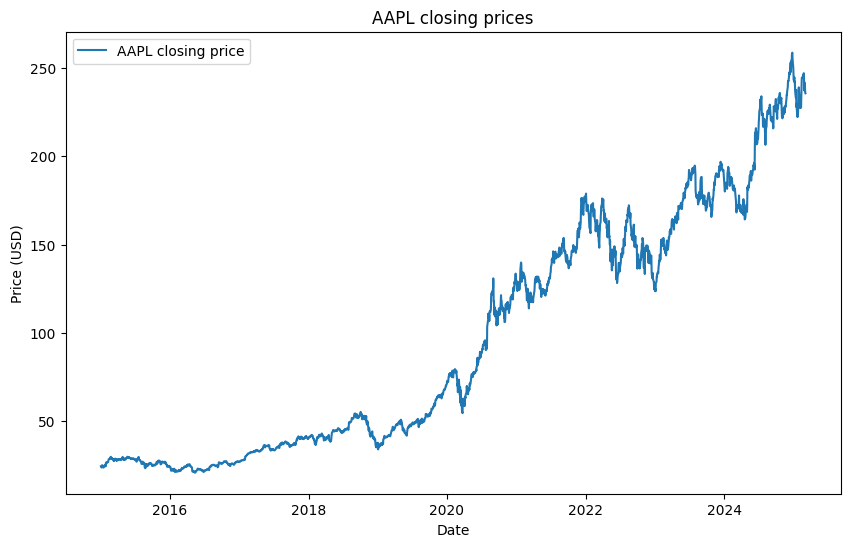

In [5]:
def plot_stock_price(stock_data, ticker):

     # Plot the closing price data
    plt.figure(figsize=(10, 6))
    plt.plot(stock_data['Close'], label=f"{ticker} closing price")
    plt.title(f"{ticker} closing prices")
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()

plot_stock_price(stock_data, chosen_stock)